In [1]:
import numpy as np
import math
from scipy.linalg import expm
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.animation as ani 

In [23]:
import sympy as sym

In [2]:
def position(H):
    P = np.zeros(len(H))
    P[math.ceil(len(P)/2)-1] = 1
    G = np.zeros(len(H))
    for i in range(len(H)):
        G[i] = i
    return P, G

def unitary_evolution(H, P, t):
    x = np.dot(1j,H)
    U = expm(np.dot(t,x))
    psi = np.matmul(P,U)
    return psi

In [78]:
def line(N):
    a = np.zeros((1, N))[0]
    b = np.ones((1, N-1))[0]
    H = np.diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    return H 

def loop(N):
    a = np.zeros((1, N))[0]
    b = np.ones((1, N-1))[0]
    H = np.diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    H[0][N-1] = 1
    H[N-1][0] = 1
    return H 

def loop_plus(N):
    a = np.zeros((1, N))[0]
    b = np.ones((1, N-1))[0]
    H = np.diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    H[0][N-1] = 1
    H[N-1][0] = 1
    H[0][2] = 1
    H[2][0] = 1
    return H 

def peterson(N):
    graph = nx.petersen_graph()
    A = nx.linalg.graphmatrix.adjacency_matrix(graph)
    H = np.array(A.todense())
    return H 

def mobius(N):
    graph = nx.moebius_kantor_graph()
    A = nx.linalg.graphmatrix.adjacency_matrix(graph)
    H = np.array(A.todense())
    return H 

def ladder(N):
    graph = nx.ladder_graph(N)
    A = nx.linalg.graphmatrix.adjacency_matrix(graph)
    H = np.array(A.todense())
    return H 

def plot_graph(graph,N):
    H = graph(N)
    A = nx.from_numpy_matrix(np.array(H))  
    nx.draw_circular(A, with_labels=True)
    plt.title(f'{graph.__name__} Graph')
    plt.show()

In [14]:
def prob_dis(hadamard, N, t):
    """Function that takes in an adjacency matrix to calculate the unitary evolution, and returns the probability distribution"""
    H = hadamard(N)
    #defining the position array and central vertex
    P, G = position(H)

    #unitary evolution
    prob = 0
    psi_i = unitary_evolution(H, P, t)
    for k in range(len(psi_i)):
        psi_i[k] = abs(psi_i[k])**2
        prob += psi_i[k]

    return G,psi_i,t

def plot_probs(G,psi_i,t):
    plt.bar(G, psi_i, color='navy')
    plt.title(f'Continuous Time Quantum Walk after {t} seconds')
    plt.xlabel('Position')
    plt.ylabel('Probability')
    plt.show()

In [22]:
def contour_dis(hadamard, N, tstart, tend):
    """Function that takes in an adjacency matrix to calculate the unitary evolution, and returns the probability distribution as a contour plot and the probabilities"""
    H = hadamard(N)
    #defining the position array and central vertex
    P, G = position(H)
    #define time array
    T = np.linspace(tstart,tend,int((tend-tstart)*5))
    #defining 'z' array for probabilities
    Z = np.zeros((len(G), len(T))) 
    probs = []

    #unitary evolution for each time step
    for i in range(len(T)):
        t_i = T[i]
        prob = 0
        psi_i = unitary_evolution(H, P, t_i)
        for k in range(len(psi_i)):
            psi_i[k] = abs(psi_i[k])**2
            prob += psi_i[k]
        probs.append(round(prob,3))
        #mapping the probability to the 2D z array
        for j in range(len(G)):
            Z[j][i] = psi_i[j]

    return T,G,Z,probs

def plot_contour(T,G,Z,probs,tstart,tend):
    plt.contourf(T,G,Z, cmap='YlOrRd')
    plt.colorbar(label='Probability')
    plt.clim(0,1.0)
    plt.title(f'Continuous Time Quantum Walk for {tend-tstart} seconds')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Position')
    plt.show()

    plt.plot(T, probs)
    plt.title('Total Probability')
    plt.xlabel('Time')
    plt.ylabel('Total Probability')  
    plt.show() 

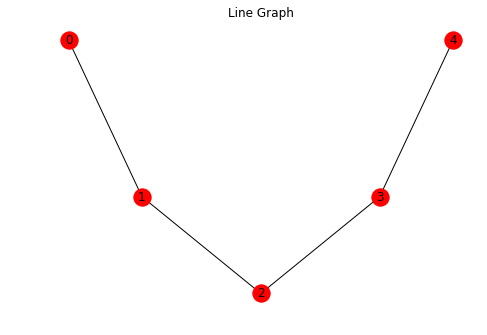

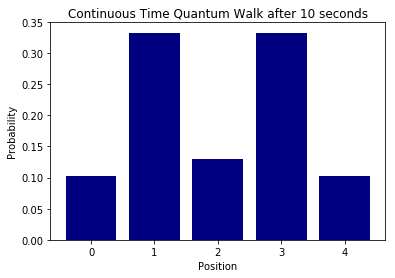

In [15]:
G, psi_i, t = prob_dis(line, 5, 10)
plot_probs(G,psi_i,t)

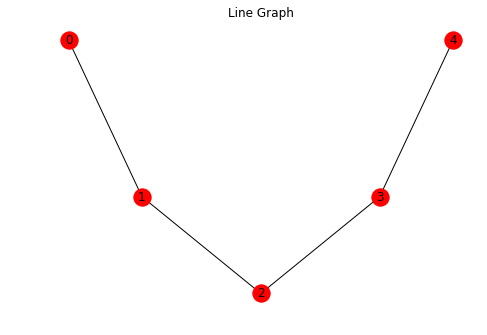

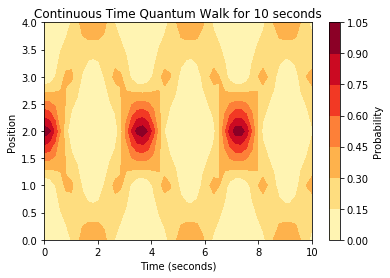

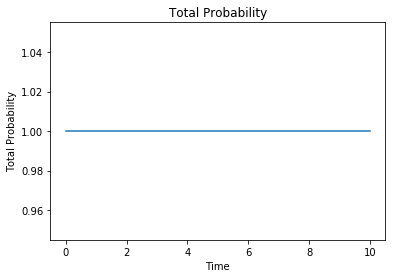

In [21]:
T,G,Z,probs = contour_dis(line, 5, 0, 10)
plot_contour(T,G,Z,probs,0,10)

In [56]:
t = sym.Symbol('t', real=True)
def matrix_exp(H):
    H = sym.Matrix(H)*t
    P,D = H.diagonalize()
    return (P*D.exp()*P**-1).subs(t,t*1j)

In [18]:
#Calculating the fisher information for the 2 node line case
H = sym.Matrix([[0,1],[1,0]])
u_ctqw = (H*1j*t).exp()
state_0 = [1,0]
state_1 = [0,1]
states = [state_0, state_1]
fish = 0
for i in range(len(states)):
    psi_k = sym.Matrix(states[int(np.floor(2/2))])
    psi_kt = u_ctqw*psi_k
    psi_j = sym.Matrix(states[i]).T

    prob = psi_j*psi_kt
    prob = sym.simplify(sym.Abs(prob)**2)
    prob = prob[0]
    dprob = sym.diff(prob,t)
    fish_xx = ((1/prob)*(dprob**2))
    print(sym.simplify(fish_xx))
    print()
    fish += fish_xx
print(sym.simplify(fish))

4.0*cos(t)**2

4.0*sin(t)**2



In [94]:
def fisher(N, S, graph):
    """Function that calulates the Fisher Information for an N node graph, starting at node S (0-(N-1))"""
    states = []
    for n in range(N):
        state = np.zeros(N)
        state[n] = 1
        states.append(state)

    H = graph(N)
    u_ctqw = matrix_exp(H)


    psi_k = sym.Matrix(states[np.int(S)]) 
    psi_kt = u_ctqw*psi_k

    fish = 0
    prob_dis = []
    fish_dis = []
    for i in range(len(states)):
        psi_j = sym.Matrix(states[i]).T

        prob = psi_j*psi_kt
        prob = sym.simplify(sym.Abs(prob)**2)
        prob = prob[0]
        prob_dis.append(prob)
        dprob = sym.diff(prob,t)
        fish_xx = ((1/prob)*(dprob**2))
        fish_dis.append(fish_xx)
        fish += fish_xx   

    return fish, prob_dis, fish_dis

def plot_fisher(fish,prob_dis,fish_dis,tend,N,S):
    X = np.linspace(0.1,tend,100)
    Y = np.linspace(0.1,tend,50)
    P = []
    F = []
    Ft = []
    for n in range(N):
        p = []
        f = []
        for x in X:
            p.append(sym.re((prob_dis[n]).evalf(subs={t:x})))
            f.append(sym.re((fish_dis[n]).evalf(subs={t:x})))
        P.append(p)
        F.append(f)
    for y in Y:
        Ft.append(sym.re(fish.evalf(subs={t:y})))

    for n in range(N):
        plt.scatter(X, P[n], label=f'Node {n}', marker='x')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'CTQW on {N} Node Graph - Start Position {S}')
    plt.xlabel('Time (s)')
    plt.ylabel('Probability')
    plt.show()

    for n in range(N):
        plt.scatter(X, F[n], label=f'Node {n}', marker='x')
    plt.scatter(Y,Ft, label='Total Fisher Info', marker='x', c='red')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'CTQW on {N} Node Graph - Start Position {S}')
    plt.xlabel('Time (s)')
    plt.ylabel('Fisher Information')
    plt.show() 

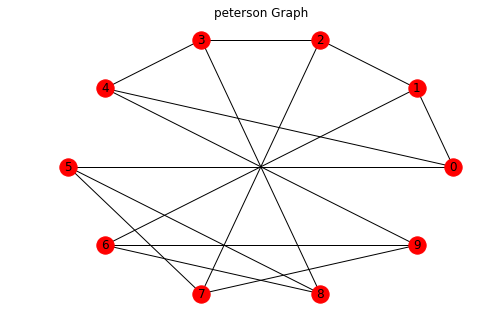

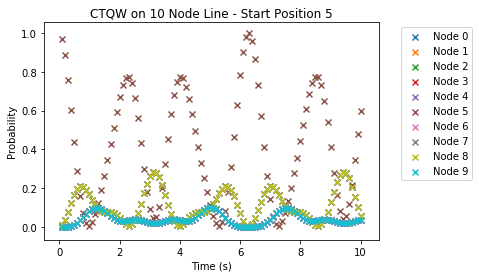

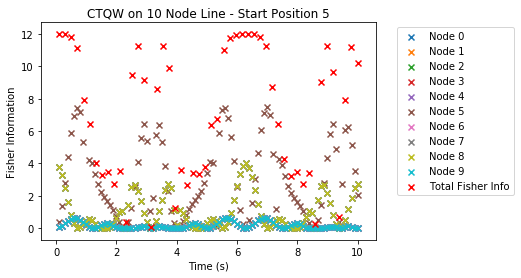

In [93]:
N = 10
S = 5
plot_graph(peterson,10)
fish, probs_dis, fish_dis = fisher(N,S,peterson)
plot_fisher(fish,probs_dis,fish_dis,10,N,S)

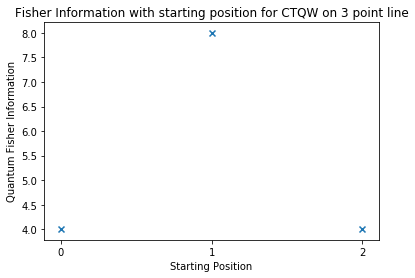

In [26]:
nodes = []
F = []
N = 3

states = []
for n in range(N):
    state = np.zeros(N)
    state[n] = 1
    states.append(state)

H = sym.Matrix(line_hadamard(N))
u_ctqw = (H*1j*t).exp()

for n in range(N):
    psi_k = sym.Matrix(states[n]) #[1,0,0]
    psi_kt = u_ctqw*psi_k
    nodes.append(n)

    fish = 0
    for i in range(len(states)):
        psi_j = sym.Matrix(states[i]).T

        prob = psi_j*psi_kt
        prob = sym.simplify(sym.Abs(prob)**2)
        prob = prob[0]
        dprob = sym.diff(prob,t)
        fish_xx = ((1/prob)*(dprob**2))
        fish += fish_xx

    F.append(sym.re(fish.evalf(subs={t:10})))

plt.scatter(nodes,F, marker='x')
plt.xlabel('Starting Position')
plt.xticks(nodes)
plt.ylabel('Quantum Fisher Information')
plt.title(f'Fisher Information with starting position for CTQW on {N} point line')
plt.show()